# Lab6 DBSCAN

This week's exercise will focus on density-based clustering using DBSCAN

Schedule:
* Implement the core of DBSCAN
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from collections import deque

pd.options.mode.chained_assignment = None

## Take a look at the data

In [3]:
# generate 2d moons dataset
X, _ = make_moons(n_samples=100, noise=0.1)
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1]))

features = ['x0', 'x1']

print(data.columns)

Index(['x0', 'x1'], dtype='object')


In [4]:
# Standardize features
data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

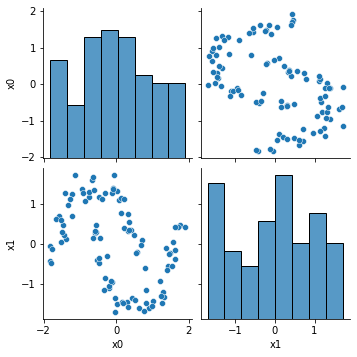

In [5]:
sns.pairplot(data, vars=features)

The scatter plot gives us a visual overview of the possible clusters. Let's see what happens when we try to partition the data with K-means (implemented in `sklearn.clusters`). Let's set K to 2.

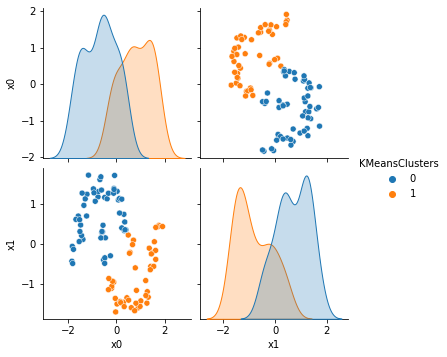

In [6]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[features])
data['KMeansClusters'] = pd.Series(kmeans.labels_)

sns.pairplot(data, vars=features, hue='KMeansClusters')

We can see that *K-Means* is not an appropriate clustering algorithm for this kind of dataset. Let's try to use **DBSCAN**, a density-based algorithm, and see if we can achieve better results.

**Spoiler: We will**

In [7]:
# You might want to play around with the parameters "epsilon" and "min_samples" and see which results you can get
DBSCANClustering = DBSCAN(eps=0.4, min_samples=4).fit(data[features])
data['DBSCANClusters'] = pd.Series(DBSCANClustering.labels_)

c:\users\frass\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\frass\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


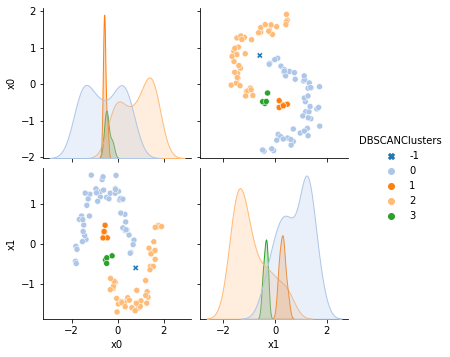

In [8]:
clusterNames = data['DBSCANClusters'].unique()
clusterNames.sort()

n_clusters = len(clusterNames)

# Use circles for clusters ("o") and crosses for outliers ("x")
markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(data, vars=features, hue='DBSCANClusters', palette=sns.color_palette("tab20", n_clusters), markers=markers)

In [9]:
# Let's go back to the original dataset:
data = data.drop('KMeansClusters', axis=1)
data = data.drop('DBSCANClusters', axis=1)
data.head()

,x0,x1
0,-1.816189,-0.055462
1,-0.547580,0.470913
2,0.349519,0.552905
3,-0.479274,1.166940
4,0.087835,1.102644


# DBSCAN

### Check the Presentation in "./Lab6 - DBSCAN Implementation Example.pdf" for a better understanding

[DBSCAN Algorithm](https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d)
### Implement the DBSCAN function:
1. Initialize the *visited* set and assign all points to cluster=-1 (outliers)
2. Implement the function *neighbourhood(x)* that returns the neighbourhood of a point x (return a list of indices)
3. Implement the function *cluster_formation(startIndex)* (See next section)
4. For each unvisited point in the dataset
  1. Start a cluster formation
  2. If a cluster has been formed (if the current point is not an outlier), increment the *currentCluster* number

### Define the function *cluster_formation(startIndex)*
1. Add start index to the *visited* set
2. Initialize a queue (*deque* from the *collections* package) and add startIndex to it
3. While the queue is not empty...
  1. Pop *currentIndex* from the queue
  2. Find the neighbourhood of the point at index *currentIndex*
  3. If len(neighbourhood)>min_samples, *currentIndex* is a core point and:
    1. Assign the current point and its neighbours to the *currentCluster* (you can use pandas' ***at*** method)
    2. Add the non-visited neighbours to the queue of points to visit and to the visited set
  4. Return whether or not a cluster has been formed.
  
### Tips
- 
### Visualizing DBSCAN Algorithm [(link)](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
Naftali Harris has created a great web-based visualization of running DBSCAN on a 2-dimensional dataset. Try clicking on the “Smiley” dataset and hitting the GO button.

In [10]:
def DBSCAN(data, epsilon=0.25, min_samples=3):
    
    # 1a - Set of the indices of points that have been already visited
    visited = set()
    
    # 1c - Initialize every point as an outlier (Cluster = -1)
    data = data.assign(Cluster=pd.Series([-1] * len(data)))
    
    currentCluster = 0
    
    def neighbourhood(x):
        # Find the distance between x and every point in the dataset
        distances = data[features].sub(x[features]) \
            .pow(2).sum(1).pow(0.5)
        # Return the list of indices of the points that are at distance <= epsilon
        ## YOUR CODE HERE
        return distances.loc[(distances <= epsilon)].index.tolist()
    
    # This function starts a cluster formation. 
    # If the starting point is a core point, add its non-visited neighbours to the queue 
    # If the starting point is not a core point, the cluster formation stops and False is returned
    def cluster_formation(startIndex):
        visited.add(startIndex)
        aClusterHasBeenFormed = False
        
        # Queue of the indices of points that are in the neighbourhood of a core point, but that have not been visited yet
        pointsToAddToCurrentCluster = deque()
        pointsToAddToCurrentCluster.append(startIndex)
        
        # Start the cluster formation: While the queue is not empty...
        while len(pointsToAddToCurrentCluster) > 0:
            # ... Pop from the queue to get the current point
            currentIndex = pointsToAddToCurrentCluster.popleft()
            
            # Get the neighbours of the point at index currentIndex
            ## YOUR CODE HERE
            neighbours = neighbourhood(data.loc[currentIndex])
            
            # If the current point is a core point...
            ## YOUR CODE HERE
            if(len(neighbours) >= min_samples):
                aClusterHasBeenFormed = True
                
                # Assign the current point and its neighbours to the current cluster
                ## YOUR CODE HERE
                data.at[currentIndex, 'Cluster'] = currentCluster
                data.at[neighbours, 'Cluster'] = currentCluster
                
                # Add the non-visited neighbours to the queue of points to visit and to the visited set
                ## YOUR CODE HERE
                for neighbourIndex in neighbours:
                    if not neighbourIndex in visited:
                        visited.add(neighbourIndex)
                        pointsToAddToCurrentCluster.append(neighbourIndex)
        return aClusterHasBeenFormed
    
    # For each unvisited point in the dataset, start a cluster formation
    for rowIndex in data.index:
        if rowIndex in visited:
            continue
            
        aClusterHasBeenFormed = cluster_formation(rowIndex)
        
        # if a cluster has been formed (= if the current row is not an outlier),
        # increment the currentCluster number
        if aClusterHasBeenFormed:
            currentCluster += 1
    
    return data

In [11]:
new_data = DBSCAN(data, epsilon=0.4, min_samples=4)

In [12]:
new_data

,x0,x1,Cluster
0,-1.816189,-0.055462,0
1,-0.547580,0.470913,1
2,0.349519,0.552905,0
3,-0.479274,1.166940,0
4,0.087835,1.102644,0
...,...,...,...
95,-0.091728,1.365842,0
96,-0.590944,0.315141,1
97,0.759576,-1.664942,2
98,-0.869183,1.070185,0


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

c:\users\frass\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\frass\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


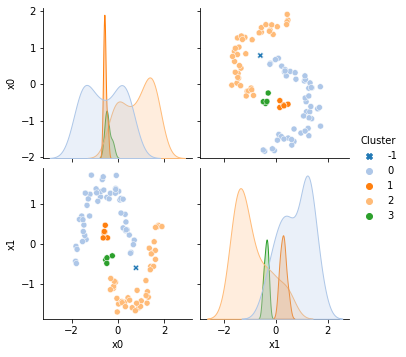

In [13]:
clusterNames = new_data['Cluster'].unique()
clusterNames.sort()
n_clusters = len(clusterNames)

markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(new_data, vars=features, hue='Cluster', palette=sns.color_palette("tab20", n_clusters), markers=markers)